In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from random import *
from math import log
import copy
pd.set_option('display.max_columns', None)
from pandas.io.json import json_normalize

from scipy.stats.stats import pearsonr   
%matplotlib inline

In [2]:
# load business and user data
with open('dataset/business.json') as f:
    business_data = [json.loads(line) for line in f]
with open('dataset/user.json') as f:
    user_data = [json.loads(line) for line in f]  

In [3]:
# preprocessed file with reviews only for restaurants
with open('dataset/restaurant_reviews.json', encoding = 'utf-8') as f:
    review_data = [json.loads(line) for line in f]

In [4]:
# convert array to list (how preprocessed file was formatted)
restaurant_reviews = review_data[0]

In [5]:
# pull just restaurant data from business data
restaurant_data = [x for x in business_data if 'Restaurants' in x['categories']]

In [6]:
del review_data
del business_data

In [7]:
# pandas dataframe of restaurant data
restaurant_df = json_normalize(restaurant_data)

In [8]:
# take 100000 reviews as sample
data_array = (np.random.choice(restaurant_reviews, size = 100000))
data_set = list(data_array)

In [9]:
# find all categories for one-hot encoding purposes
from collections import Counter
all_categories = []
for r in restaurant_data:
    if 'Restaurants' in r['categories']:
        for c in r['categories']:
            all_categories.append(c)

In [10]:
# take 150 most popular categories
counts = list (Counter(all_categories).items())
counts.sort(key=lambda x: x[1], reverse = True)
most_popular = [x[0] for x in counts[:150]]

In [11]:
# create restaurant and user dictionaries for easy lookup
restaurant_dict = {}
for item in restaurant_data:
    restaurant_id = item['business_id']
    restaurant_dict[restaurant_id] = item

user_dict = {}
for item in user_data:
    user_id = item['user_id']
    user_dict[user_id] = item

In [12]:
# make copy of the reviews array
expanded_reviews = copy.deepcopy(data_array)

In [13]:
# add business and user info
for review in expanded_reviews:
    #print (review)
    restaurant = review['business_id']
    user = review['user_id']
    restaurant_info = restaurant_dict[restaurant]
    #print (restaurant_info)
    user_info = user_dict[user]
    for attribute in restaurant_info:
        #print (attribute)
        if attribute not in ['is_open', 'latitude','longitude','name','business_id',
                             'neighborhood','address','city','postal_code','hours']:
            if attribute == 'categories':
                for c in most_popular:
                    if c in restaurant_info[attribute]:
                        review['R_' +  c] = 1
                    else:
                        review['R_' +  c] = 0
            else:         
                review['R_' + attribute] = restaurant_info[attribute]
    for attribute in user_info:
        if attribute not in ['user_id','name']:   
            if attribute == 'friends':
                review['U_friends'] = len(user_info[attribute])
            elif attribute == 'yelping_since':
                review['U_yelping_since'] = user_info[attribute][:4]
            elif attribute == 'elite':
                if user_info[attribute]:
                    review['U_elite'] = True
                else:
                    review['U_elite'] = False        
            else:
                review['U_' + attribute] = user_info[attribute] 

In [14]:
# create pandas dataframe
flatframe = json_normalize(expanded_reviews)
flatframe = flatframe.drop(['text','useful','funny','cool','date'], axis=1)

In [15]:
# change user since
flatframe['U_years_yelping'] = [2015 - int(x) for x in flatframe['U_yelping_since']]
flatframe.drop(['U_yelping_since'],axis = 1, inplace = True)

In [16]:
# drop ids
flatframe_wids = flatframe.drop(['business_id', 'review_id', 'user_id'], axis = 1)

In [17]:
#one hot encode
flatframe_wids = pd.get_dummies(flatframe_wids, columns = ['R_state', 
                                                    'R_attributes.Alcohol', 'R_attributes.AgesAllowed', 'R_attributes.RestaurantsAttire',
                                                    'R_attributes.RestaurantsPriceRange2','R_attributes.Smoking',
                                                    'R_attributes.WiFi', 'R_attributes.NoiseLevel','R_attributes.BYOBCorkage'])

In [18]:
# drop column if more than half of a column is nan
nan_count = {}
for column in flatframe_wids:
     nan_count[column] = flatframe_wids[column].isnull().sum()

nan_sorted = sorted(nan_count.items(), key=lambda x: x[1], reverse = True) 
drop_nans = [x[0] for x in nan_sorted if x[1] > 50000]

In [19]:
# drop some nans and fill some nans
flatframe_wids = flatframe_wids.drop(drop_nans, axis = 1)
flatframe_wids = flatframe_wids.fillna(flatframe_wids.mean())

In [20]:
# train test split
msk = np.random.rand(len(flatframe_wids)) < 0.5
data_train = flatframe_wids[msk]
data_test = flatframe_wids[~msk]

In [21]:
# make pandas dataframe for user data
user_df = json_normalize(user_data)

In [22]:
# train test split including business ids and user ids
data_train_temp = flatframe[msk]
data_test_temp = flatframe[~msk]

In [23]:
# global user average
users = data_train_temp.user_id.unique()
user_total = user_df[user_df['user_id'].isin(users)]['average_stars']
global_user_average = sum(user_total)/len(user_total)

In [24]:
# global restaurant average
restaurants = data_train_temp.business_id.unique()
restaurant_total = restaurant_df[restaurant_df['business_id'].isin(restaurants)]['stars']
global_restaurant_average = sum(restaurant_total)/len(restaurant_total)

In [25]:
# global review average
global_review_average = data_train['stars'].mean()

In [26]:
# user biases
user_deviations = {}
for item in user_data:
    user_id = item['user_id']
    user_deviations[user_id] = item['average_stars'] - global_user_average

In [27]:
# restaurant biases
restaurant_deviations = {}
for item in restaurant_data:
    rest_id = item['business_id']
    restaurant_deviations[rest_id] = item['stars'] - global_restaurant_average

In [28]:
# creating xy variables
Xtrain = data_train.drop(['stars'], axis = 1)
ytrain = data_train['stars']
Xtest = data_test.drop(['stars'], axis = 1)
ytest = data_test['stars']

In [29]:
def baseline(user_id, business_id):
    pred = global_review_average + user_deviations[user_id] + restaurant_deviations[business_id]
    return int(round(pred))

In [30]:
# predictions
base_pred = [baseline(x,y) for x,y in zip(data_train_temp['user_id'],data_train_temp['business_id'])]
base_pred_test = [baseline(x,y) for x,y in zip(data_test_temp['user_id'],data_test_temp['business_id'])]

In [31]:
# calculate averages
pred_df_train = pd.DataFrame({'y' : ytrain, 'ypred' : base_pred})
pred_df_test = pd.DataFrame({'y' : ytest, 'ypred' : base_pred_test})

base_pred_avg = []
base_pred_test_avg = []
for i in [1, 2, 3, 4, 5]:
    base_pred_avg.append(pred_df_train[pred_df_train['y'] == i]['ypred'].mean())
    base_pred_test_avg.append(pred_df_test[pred_df_test['y'] == i]['ypred'].mean())

In [32]:
model = LinearRegression()
model.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [33]:
ypred = model.predict(Xtrain)
ypred_test = model.predict(Xtest)
predround = [int(round(x)) for x in ypred]
predround_test = [int(round(x)) for x in ypred_test]

In [34]:
model_lasso = LassoCV().fit(Xtrain, ytrain)

In [35]:
lasso_ypred = model_lasso.predict(Xtrain)
lasso_ypred_round = [int(round(x)) for x in lasso_ypred]
lasso_ypred_test = model_lasso.predict(Xtest)
lasso_ypred_test_round = [int(round(x)) for x in lasso_ypred_test]

In [36]:
model_ridge = RidgeCV().fit(Xtrain, ytrain)

In [37]:
ridge_ypred = model_ridge.predict(Xtrain)
ridge_ypred_round = [int(round(x)) for x in ridge_ypred]
ridge_ypred_test = model_ridge.predict(Xtest)
ridge_ypred_test_round = [int(round(x)) for x in ridge_ypred_test]

In [38]:
# calculate averages
pred_df_train = pd.DataFrame({'y' : ytrain, 'ypred' : ridge_ypred_round})
pred_df_test = pd.DataFrame({'y' : ytest, 'ypred' : ridge_ypred_test_round})

ridge_pred_avg = []
ridge_pred_test_avg = []
for i in [1, 2, 3, 4, 5]:
    ridge_pred_avg.append(pred_df_train[pred_df_train['y'] == i]['ypred'].mean())
    ridge_pred_test_avg.append(pred_df_test[pred_df_test['y'] == i]['ypred'].mean())

## Part 4: A Different Model

### Naive kNN Model

In [39]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
knn.fit(Xtrain, ytrain)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform')

We used a KNeighborsRegressor model as we felt that a regressor was more appropriate than a classifier because although the y-variable was categorical (1, 2, 3, 4, 5), it was also ordinal.

In [40]:
ypred_train = np.round(knn.predict(Xtrain)).astype(int)
ypred_test = np.round(knn.predict(Xtest)).astype(int)

In [41]:
print ("The accuracy score of the knn model on the train set is {}"
       .format(metrics.accuracy_score(ytrain, ypred_train)))
print ("The accuracy score of the knn model on the test set is {}"
       .format(metrics.accuracy_score(ytest, ypred_test)))

The accuracy score of the knn model on the train set is 0.34845241191652826
The accuracy score of the knn model on the test set is 0.27967372398488577


### Cross-Validation

In [42]:
from sklearn.model_selection import KFold
means = []

for i in range(1, 11):
    knn = KNeighborsRegressor(n_neighbors=i, n_jobs=-1)
    n_folds=5
    fold = 0
    
    valid_acc = [0, 0, 0, 0, 0]
    for train, valid in KFold(n_folds, shuffle=True).split(range(len(Xtrain))):
        train_set = data_train.iloc[train]
        valid_set = data_train.iloc[valid]
        
        X_cross_train = train_set.drop(['stars'], axis = 1)
        y_cross_train = train_set['stars']
        X_cross_valid = valid_set.drop(['stars'], axis = 1)
        y_cross_valid = valid_set['stars']

        knn.fit(X_cross_train, y_cross_train)
        
        y_hat_train_cross = np.round(knn.predict(X_cross_train)).astype(int)
        y_hat_valid_cross = np.round(knn.predict(X_cross_valid)).astype(int)
        
        valid_acc[fold] = metrics.accuracy_score(y_cross_valid, y_hat_valid_cross)
        fold += 1
    print(str(i) + ', ' + str(np.mean(valid_acc)))
    means.append(np.mean(valid_acc))
    
k = (means.index(np.max(means)) + 1)
print(str(k) + " = k model has highest mean validation accuracy score at: " + str(np.max(means)))

1, 0.324723553521
2, 0.290070258372
3, 0.290070168309
4, 0.282287259207
5, 0.276865190409
6, 0.277545480531
7, 0.274244220045
8, 0.271763269677
9, 0.271623037532
10, 0.270082581397
1 = k model has highest mean validation accuracy score at: 0.324723553521


Here, we had to hard-code cross-validation (rather than using cross_val_score because the default scoring method for kNeighborsRegressor was r2, and we wanted to use classification accuracy. The mean validation accuracy consistently decreases as k increases-- k=1 is the best-performing model.

### Final kNN Model

In [43]:
knn = KNeighborsRegressor(n_neighbors=1, n_jobs=-1)
knn.fit(Xtrain, ytrain)
ypred_train = np.round(knn.predict(Xtrain)).astype(int)
ypred_test = np.round(knn.predict(Xtest)).astype(int)
print ("The accuracy score of the knn model on the train set is {}"
       .format(metrics.accuracy_score(ytrain, ypred_train)))
print ("The accuracy score of the knn model on the test set is {}"
       .format(metrics.accuracy_score(ytest, ypred_test)))

The accuracy score of the knn model on the train set is 0.9999799923971109
The accuracy score of the knn model on the test set is 0.3240568583938104


It is interesting that the highest performing model has k=1--this was true in both cross-validation and when looking at test accuracies separately (code not shown here for test accuracies of other models). This suggests that for a given user-restaurant combination, the single user-restaurant combination already in the dataset that is closest to the desired combination is most reflective of the desired combination (rather than an aggregate of several close combinations). Furthermore, this model has a relatively lower test accuracy than the baseline and the regression models, suggesting that it is not the best model to use for this dataset. Cross-validation did increase the accuracy score from the naive model (which used k = 5 as default).

In [44]:
# calculate averages
pred_df_train = pd.DataFrame({'y' : ytrain, 'ypred' : ypred_train})
pred_df_test = pd.DataFrame({'y' : ytest, 'ypred' : ypred_test})

knn_pred_avg = []
knn_pred_test_avg = []
for i in [1, 2, 3, 4, 5]:
    knn_pred_avg.append(pred_df_train[pred_df_train['y'] == i]['ypred'].mean())
    knn_pred_test_avg.append(pred_df_test[pred_df_test['y'] == i]['ypred'].mean())

(1, 5)

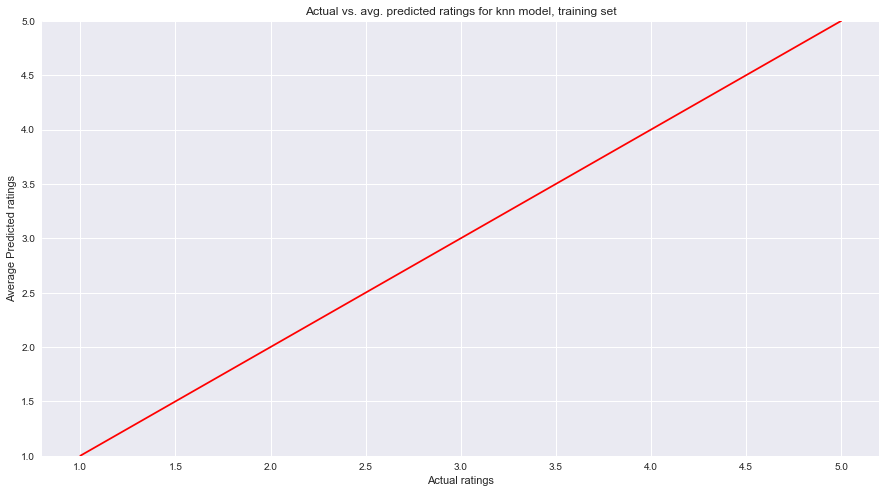

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], knn_pred_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for knn model, training set')
ax.set_ylim((1,5))

(1, 5)

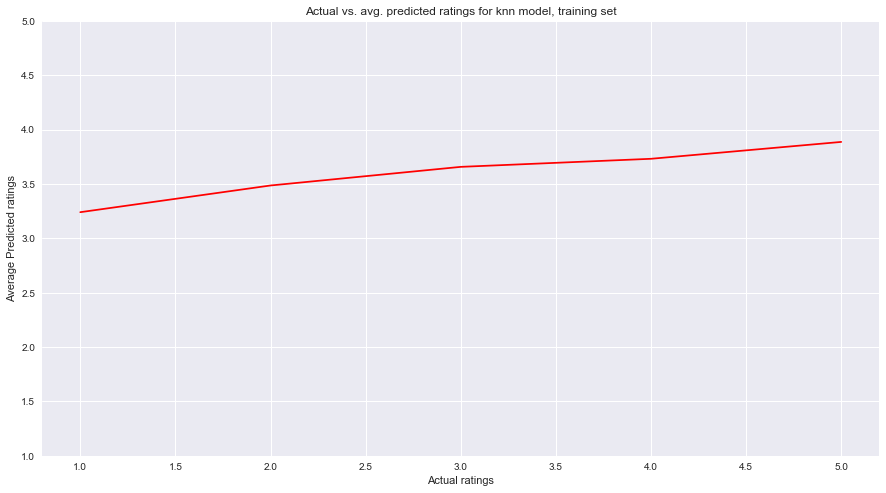

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], knn_pred_test_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for knn model, training set')
ax.set_ylim((1,5))

As k=1, the training set has a perfect match between actual ratings and predicted ratings. For the test set, however, the average predicted ratings start at around 3.25 when the actual ratings are 1 and increase slightly to about 3.75 when the actual ratings are 5 (much flatter graph than the other models).